# note4


In [39]:
from dataclasses import asdict, dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import filtfilt, firwin
from torch import nn, optim

from src.utils.load_data import load_data, path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import (
    plot_buck_gru_components_tail,
    plot_compare_tail,
    plot_iLvC,
    plot_param_learning_progress,
    plot_u_vs_iL_vC,
)
from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
)

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [40]:
keep_log: bool = True
keep_log: bool = False


@dataclass(frozen=True)
class Params:
    data_path: str = path_list.path3  # 実機
    # data_path: str = (
    #     "../../data/buck_sim_Vin10.0_Vref5.0_fs100000.0_ppc1000_cyc1000/"
    #     "buck_sim_Vin10.0_Vref5.0_fs100000.csv"
    # )  # シミュレーション
    # data_path: str = (
    #     "../../data/ltspice_sim/ltspice_sim_data.csv"  # ltspice シミュレーション
    # )

    # 真値パラメータ
    L_true: float = 223.6e-6
    C_true: float = 73.8e-6
    R_true: float = 5
    L_init = 200e-6
    C_init = 100e-6
    R_init = 8.0

    Vin: int = 10
    # Vref: int = 5
    # duty: float = Vref / Vin
    f_sw: float = 1e5  # スイッチング周波数
    T: float = 1 / f_sw  # 1周期の実時間
    cycles: int = 10
    cycles_sim: int = 1000  # この周期数分シミュレーションすれば定常であるとする
    samples_per_cycle: int = 200

    train_ratio = 0.3
    valid_ratio = 0.3
    # test_ratio = 1 - train_ratio - valid_ratio

    numtaps = 4001  # FIR長（奇数）

    clipped_k: float = 2.0

    # 学習パラメータ

    # 異なるパラメータに異なる学習率を設定
    lr_l = 5e-2
    lr_c = 1e-2
    lr_r = 2e-2

    epochs = 100000

    # GRU学習用のデータ準備（時系列データ）
    seq_length = 10

    gru_lr = 0.001
    gru_epochs = 200


params = Params()


In [41]:
# ログ保存の初期化
if keep_log:
    result_dir = create_result_dir(
        "note4",
        base_dir="results/actual",
        config_dict=asdict(params),
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note4/note.ipynb")

# BuckConverterCell


## 前処理

1. 実機データの読み込み
2. ダウンサンプリング
3. ノイズのクリッピング
4. train, valid, test に分割


len(t_raw)=250001
len(iL_raw)=250001
len(vC_raw)=250001


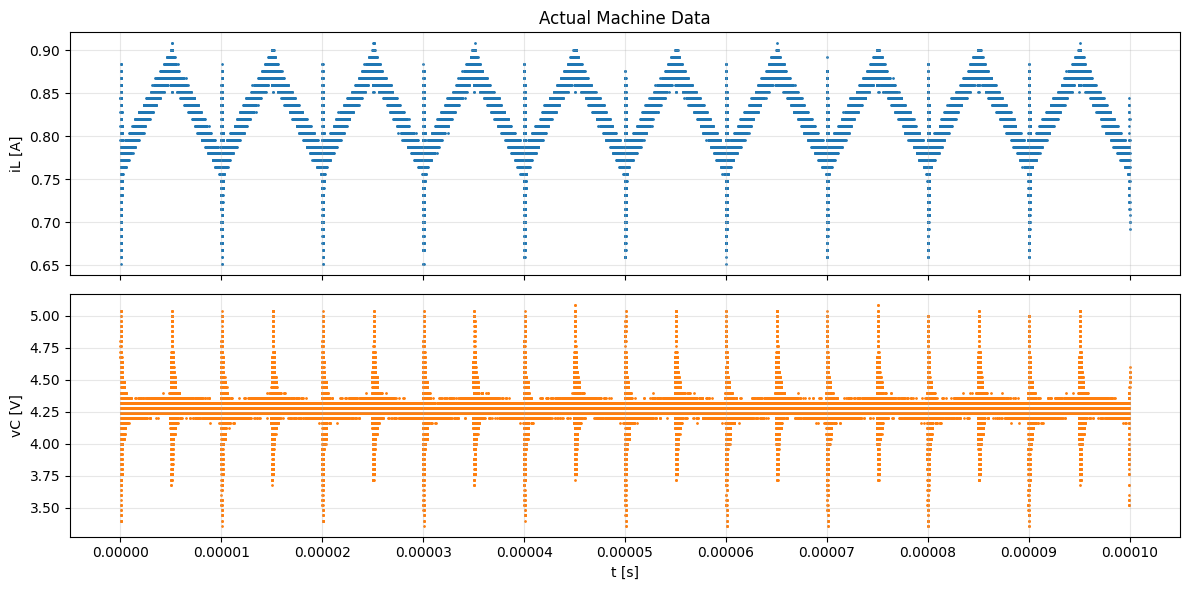

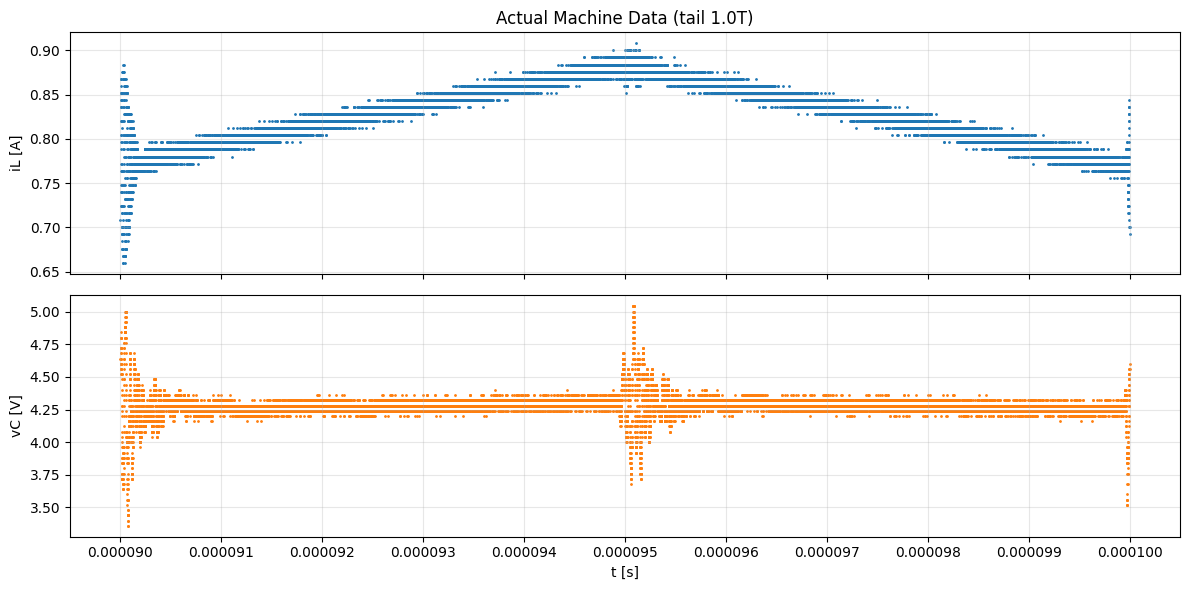

In [42]:
# データの読み込み
is_meas = params.data_path == path_list.path3
t_raw, iL_raw, vC_raw = load_data(
    path=params.data_path,
    skiprows=20 if is_meas else 0,
    downsample_step=1,  # ダウンスケールしない
    T=params.T,
    cycles=params.cycles,
    start_time_offset=5e-7 if is_meas else 0,
    time_label="TIME" if is_meas else "t",
    iL_label="CH2" if is_meas else "iL",
    vC_label="CH1" if is_meas else "vC",
)
print(f"{len(t_raw)=}")
print(f"{len(iL_raw)=}")
print(f"{len(vC_raw)=}")

fig_list = plot_iLvC(
    t_raw,
    iL_raw,
    vC_raw,
    T=params.T,
    title="Actual Machine Data",
    show_tail=(1.0,),
    plot_style="scatter",  # 点で描画
    marker=".",
    markersize=2.0,
)

if keep_log:
    for i, (fig, _) in enumerate(fig_list):
        save_figure_to_log(
            fig,
            f"実機データ(加工前)_{i}",
            result_dir,
            "実機データ(加工前)" if i == 0 else None,
        )


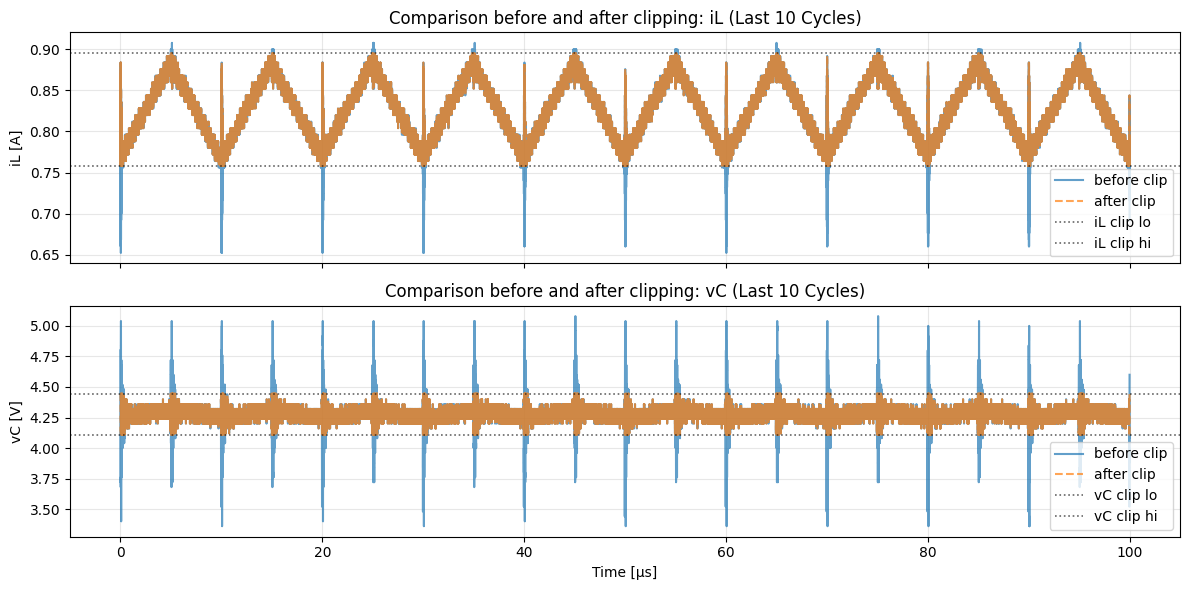

In [43]:
# ノイズのクリッピング
def clip_by_mean_std(x: np.ndarray, k: float) -> tuple[np.ndarray, float, float]:
    mu = float(np.mean(x))
    std = float(np.std(x))
    lo = mu - k * std
    hi = mu + k * std
    x_clipped = np.clip(x, lo, hi)
    return x_clipped.astype(x.dtype, copy=False), lo, hi


iL_clipped, iL_lo, iL_hi = clip_by_mean_std(iL_raw, k=params.clipped_k)
vC_clipped, vC_lo, vC_hi = clip_by_mean_std(vC_raw, k=params.clipped_k)

# プロット
fig, ax = plot_compare_tail(
    t_raw,
    iL_raw,
    vC_raw,
    "before clip",
    t_raw,
    iL_clipped,
    vC_clipped,
    "after clip",
    params.T,
    title="Comparison before and after clipping",
    iL_range=(iL_lo, iL_hi),
    vC_range=(vC_lo, vC_hi),
)
if keep_log:
    save_figure_to_log(fig, "compare_tail.png", result_dir)


In [44]:
# FIRフィルター
fs_raw = 1.0 / np.mean(np.diff(t_raw))
fc = 0.1 * params.f_sw
b = firwin(params.numtaps, fc, fs=fs_raw)
iL_filt = filtfilt(b, [1.0], iL_clipped)
vC_filt = filtfilt(b, [1.0], vC_clipped)

# ダウンサンプリング
downsample_step = len(t_raw) // (params.samples_per_cycle * params.cycles)
t_downsampled: np.ndarray = t_raw[::downsample_step]
iL_buck: np.ndarray = iL_filt[::downsample_step]
vC_buck: np.ndarray = vC_filt[::downsample_step]
iL_gru: np.ndarray = iL_raw[::downsample_step]
vC_gru: np.ndarray = vC_raw[::downsample_step]


# エッジ効果を考慮して端を切り落とす
delay = (params.numtaps - 1) // 2
delay_ds = delay // downsample_step

t_downsampled = t_downsampled[delay_ds:-delay_ds]
iL_buck = iL_buck[delay_ds:-delay_ds]
vC_buck = vC_buck[delay_ds:-delay_ds]
iL_gru = iL_gru[delay_ds:-delay_ds]
vC_gru = vC_gru[delay_ds:-delay_ds]


duty=0.42778366486534053


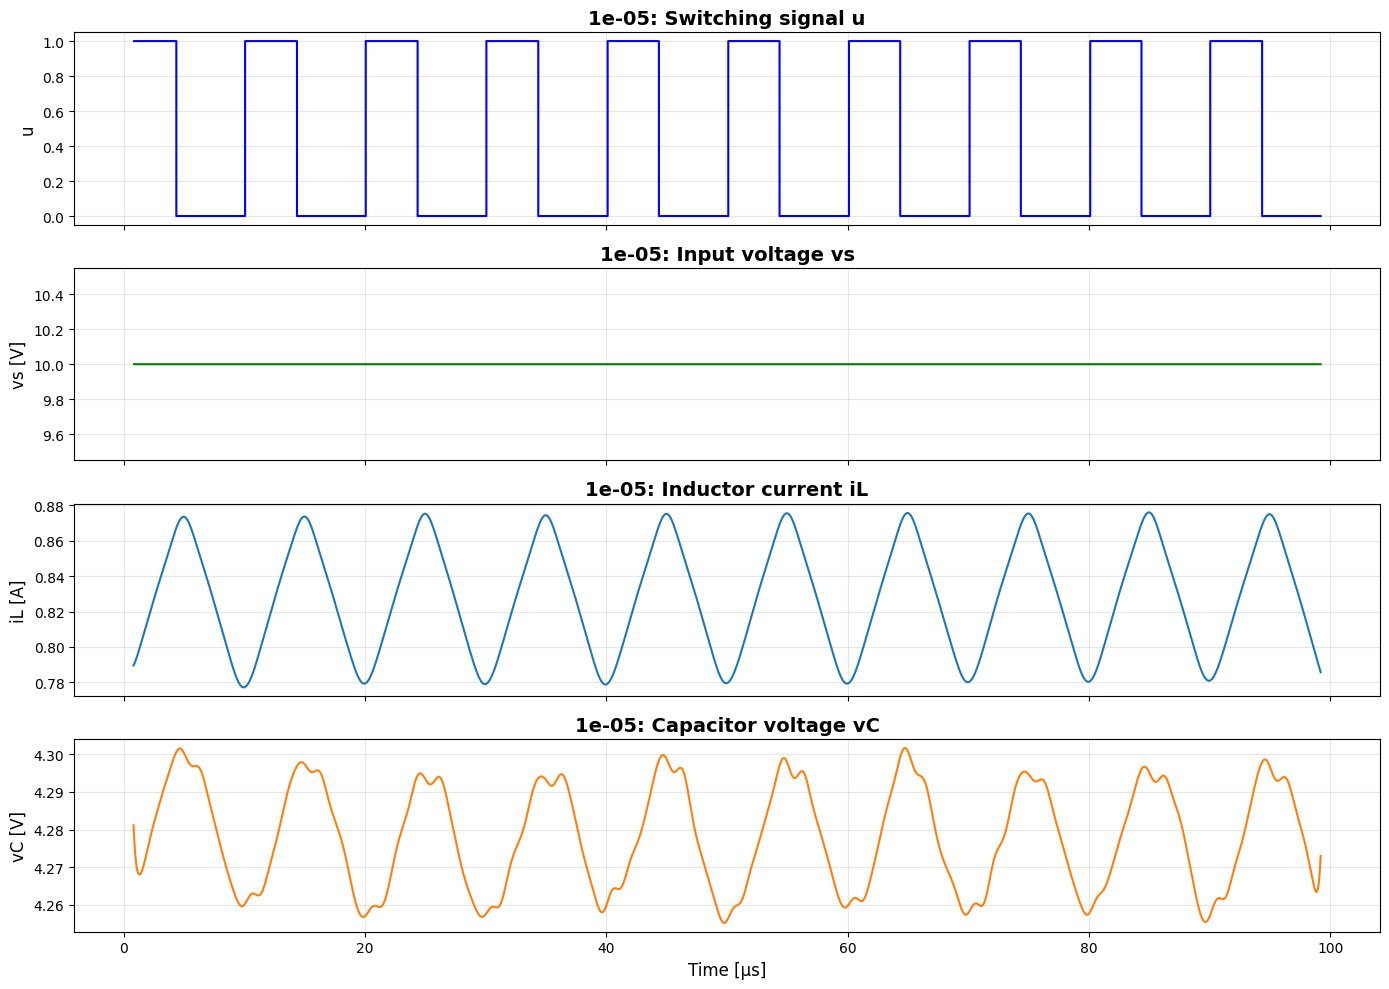

In [45]:
Vref: float = float(np.mean(vC_raw))
duty: float = Vref / params.Vin
print(f"{duty=}")


# スイッチング信号
duty_phase = (t_downsampled[:-1] % params.T) / params.T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_downsampled) - 1) * params.Vin

fig, ax = plot_u_vs_iL_vC(
    t_downsampled,
    u,
    vs,
    iL_buck,
    vC_buck,
    params.T,
)

if keep_log:
    save_figure_to_log(
        fig, "BuckConverterCellの入力波形", result_dir, "BuckConverterCellの入力波形"
    )


In [46]:
# train, valid, test の分割
dt = np.diff(t_downsampled)

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_buck_tensor = torch.tensor(iL_buck.copy(), dtype=torch.float32)
vC_buck_tensor = torch.tensor(vC_buck.copy(), dtype=torch.float32)

# train
train_len = int(len(dt) * params.train_ratio)

t_train = t_downsampled[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_buck_train = iL_buck_tensor[: train_len + 1]
vC_buck_train = vC_buck_tensor[: train_len + 1]

h_buck_train = torch.stack([iL_buck_train[:-1], vC_buck_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_buck_train = torch.stack([iL_buck_train[1:], vC_buck_train[1:]], dim=1)


# valid
valid_len = int(len(dt) * params.valid_ratio)

t_valid = t_downsampled[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_buck_valid = iL_buck_tensor[train_len : train_len + valid_len + 1]
vC_buck_valid = vC_buck_tensor[train_len : train_len + valid_len + 1]

h_buck_valid = torch.stack([iL_buck_valid[:-1], vC_buck_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_buck_valid = torch.stack([iL_buck_valid[1:], vC_buck_valid[1:]], dim=1)

# test
t_test = t_downsampled[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_buck_test = iL_buck_tensor[train_len + valid_len :]
vC_buck_test = vC_buck_tensor[train_len + valid_len :]

h_buck_test = torch.stack([iL_buck_test[:-1], vC_buck_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_buck_test = torch.stack([iL_buck_test[1:], vC_buck_test[1:]], dim=1)

print(f"{h_buck_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_buck_train.shape=}")

print(f"{h_buck_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_buck_valid.shape=}")

print(f"{h_buck_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_buck_test.shape=}")


h_buck_train.shape=torch.Size([590, 2])
x_train.shape=torch.Size([590, 3])
target_buck_train.shape=torch.Size([590, 2])
h_buck_valid.shape=torch.Size([590, 2])
x_valid.shape=torch.Size([590, 3])
target_buck_valid.shape=torch.Size([590, 2])
h_buck_test.shape=torch.Size([788, 2])
x_test.shape=torch.Size([788, 3])
target_buck_test.shape=torch.Size([788, 2])


## 学習


In [47]:
buck_converter_cell = BuckConverterCell(
    L_init=params.L_init,
    C_init=params.C_init,
    R_init=params.R_init,
)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": params.lr_l},
        {"params": [buck_converter_cell.log_C], "lr": params.lr_c},
        {"params": [buck_converter_cell.log_R], "lr": params.lr_r},
    ]
)

loss_fn = nn.MSELoss()
# loss_fn = nn.SmoothL1Loss(beta=0.1)

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(params.epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_buck_train, x_train)
    train_loss = loss_fn(h_pred_train, target_buck_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    buck_converter_cell.eval()
    with torch.no_grad():
        h_pred_valid = buck_converter_cell(h_buck_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_buck_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}\n"
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={params.L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={params.C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={params.R_true:.1f})"
        )
        print(output_line)

# テストデータでの評価
buck_converter_cell.eval()
with torch.no_grad():
    h_pred_test = buck_converter_cell(h_buck_test, x_test)
    test_loss = loss_fn(h_pred_test, target_buck_test)

print(f"Final test loss: {test_loss.item():.6e}")


Epoch 0: Train Loss=3.164796e-07, Valid Loss=2.694087e-07
  L=210.0µH (true=223.6)C=100.7µF (true=73.8)R=7.87Ω (true=5.0)
Epoch 50: Train Loss=2.413121e-07, Valid Loss=2.239937e-07
  L=282.0µH (true=223.6)C=115.1µF (true=73.8)R=4.56Ω (true=5.0)
Epoch 100: Train Loss=2.411174e-07, Valid Loss=2.231457e-07
  L=276.4µH (true=223.6)C=112.6µF (true=73.8)R=4.70Ω (true=5.0)
Epoch 150: Train Loss=2.410787e-07, Valid Loss=2.231564e-07
  L=276.7µH (true=223.6)C=109.0µF (true=73.8)R=4.71Ω (true=5.0)
Epoch 200: Train Loss=2.410432e-07, Valid Loss=2.231396e-07
  L=276.7µH (true=223.6)C=105.2µF (true=73.8)R=4.72Ω (true=5.0)
Epoch 250: Train Loss=2.410022e-07, Valid Loss=2.231200e-07
  L=276.7µH (true=223.6)C=101.3µF (true=73.8)R=4.74Ω (true=5.0)
Epoch 300: Train Loss=2.409563e-07, Valid Loss=2.230894e-07
  L=276.7µH (true=223.6)C=97.2µF (true=73.8)R=4.75Ω (true=5.0)
Epoch 350: Train Loss=2.409079e-07, Valid Loss=2.230657e-07
  L=276.7µH (true=223.6)C=93.1µF (true=73.8)R=4.77Ω (true=5.0)
Epoch 400: Tr

## 結果確認


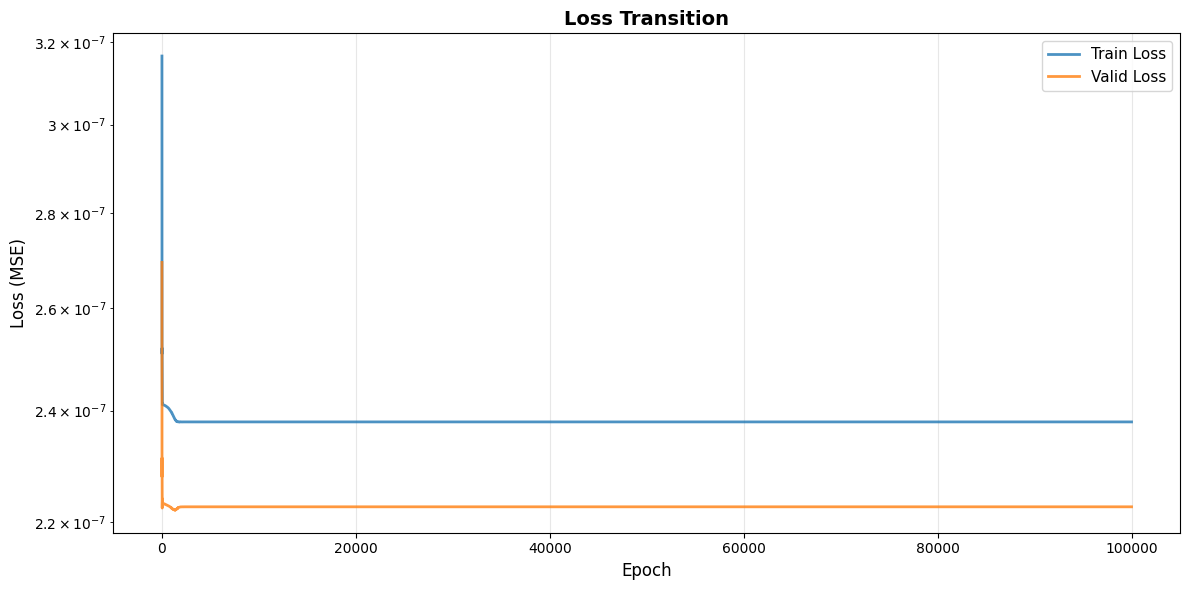

In [48]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig,
        "BuckConverterCellの学習結果_Lossの遷移",
        result_dir,
        "BuckConverterCellの学習結果_Lossの遷移",
    )


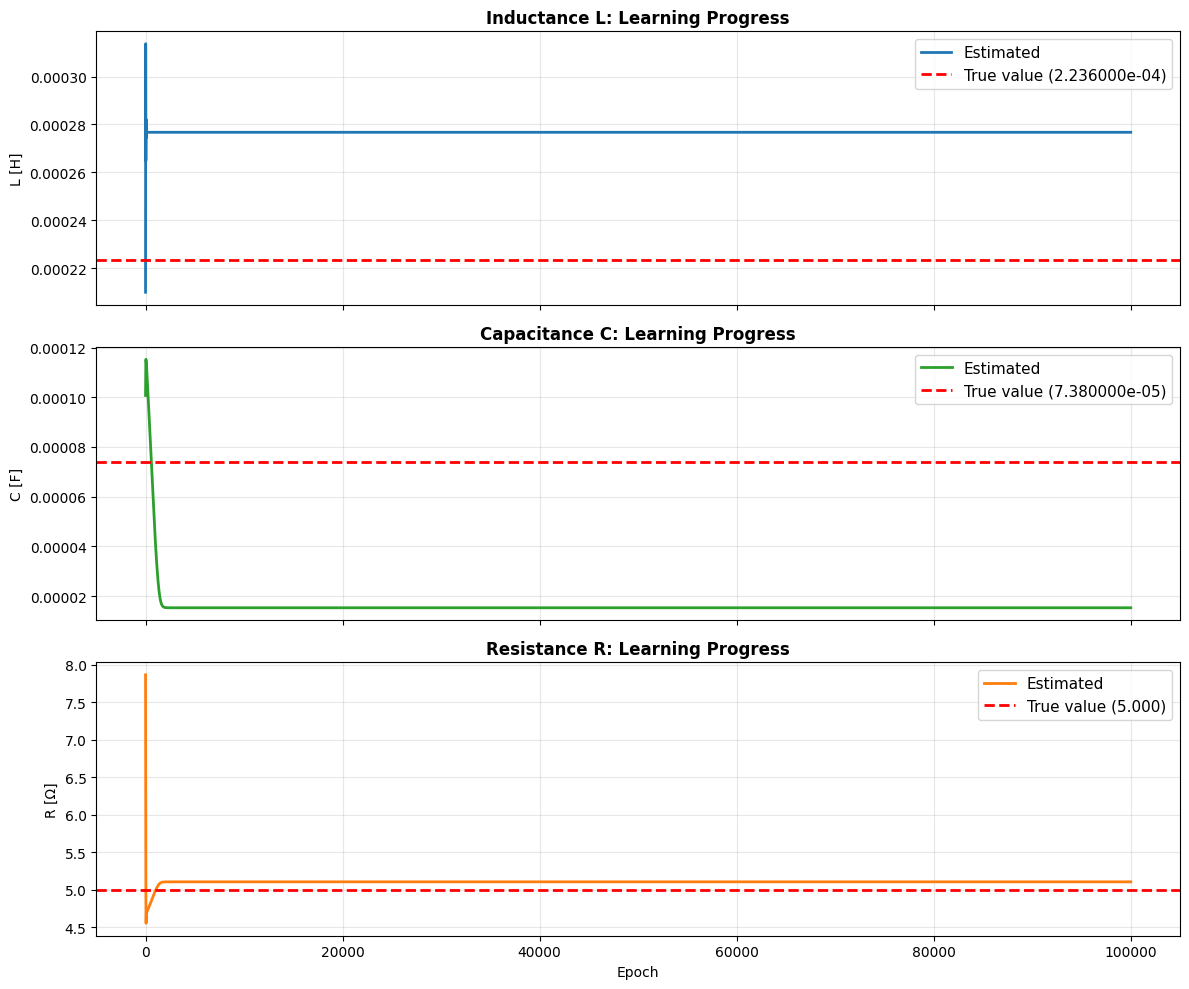

In [49]:
# 回路パラメータの学習による変化をグラフ表示
fig, ax = plot_param_learning_progress(
    param_history,
    params.L_true,
    params.C_true,
    params.R_true,
    params.epochs,
)
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )


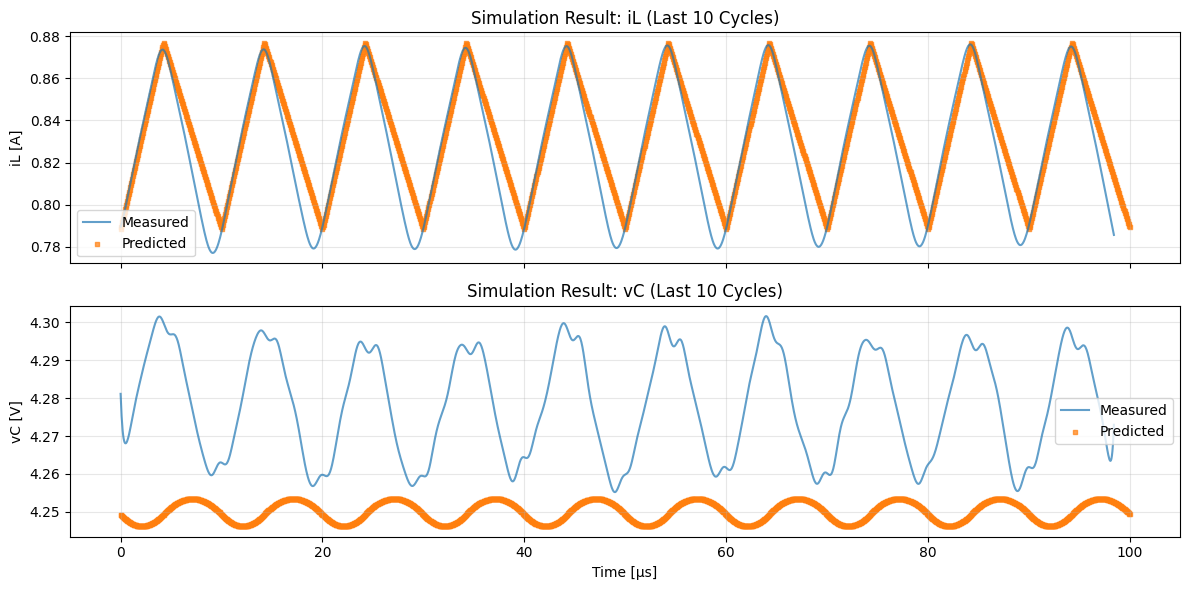

In [50]:
t_sim = np.linspace(
    0,
    params.T * params.cycles_sim,
    params.cycles_sim * params.samples_per_cycle + 1,
)


dt_sim: np.ndarray = np.diff(t_sim)


# スイッチング信号
duty_phase = (t_sim[:-1] % params.T) / params.T
u_sim = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_sim) - 1) * params.Vin
x_tensor = torch.tensor(np.c_[vs_sim, u_sim, dt_sim], dtype=torch.float32)

h_sim = [torch.zeros(1, 2)]

# シミュレーション実行
with torch.no_grad():
    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_sim[-1], x_tensor[j : j + 1])
        h_sim.append(h_current)

h_sim_tensor = torch.cat(h_sim, dim=0)  # shape: (T+1, 2) みたいになる
iL_sim = h_sim_tensor[:, 0]
vC_sim = h_sim_tensor[:, 1]

# グラフ表示
fig, ax = plot_compare_tail(
    t_downsampled,
    iL_buck,
    vC_buck,
    "Measured",
    t_sim,
    iL_sim,
    vC_sim,
    "Predicted",
    T=params.T,
    title="Simulation Result",
    style2="scatter",
)


if keep_log:
    save_figure_to_log(
        fig,
        "all_prediction",
        result_dir,
        f"シミュレーション結果(0から{params.cycles_sim}周期までシミュレーションし、定常箇所と実機のデータの比較)",
    )


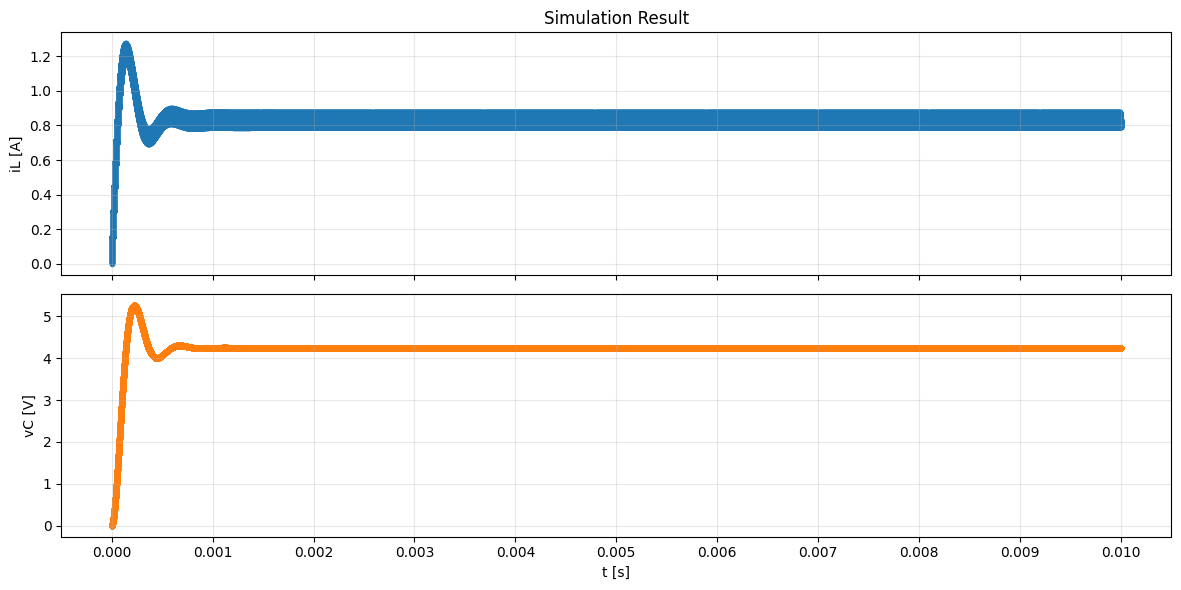

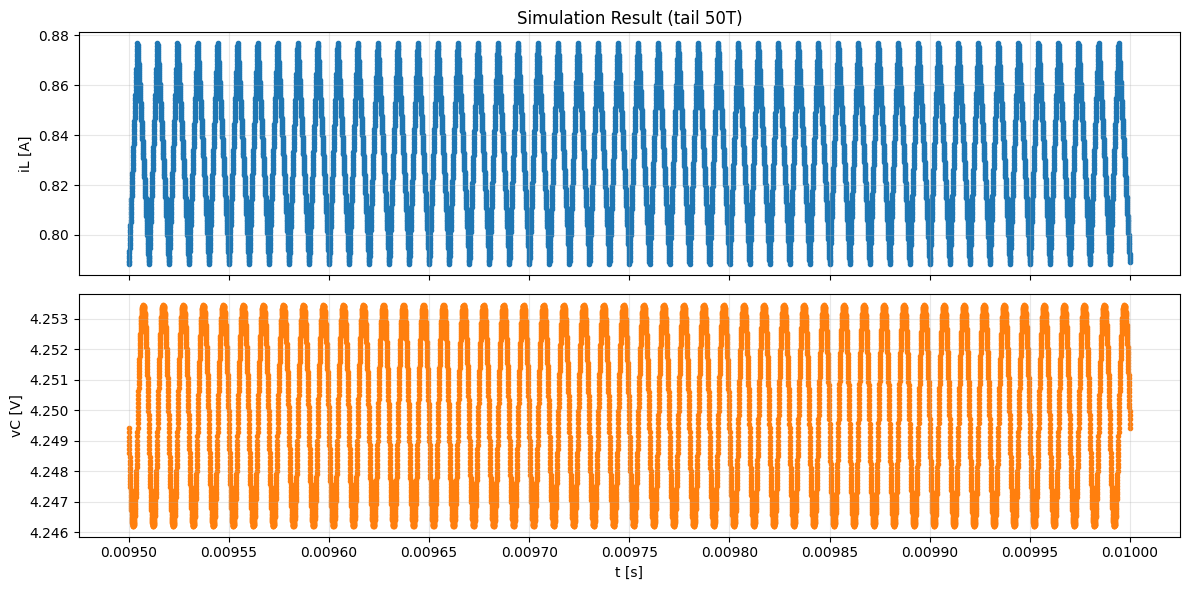

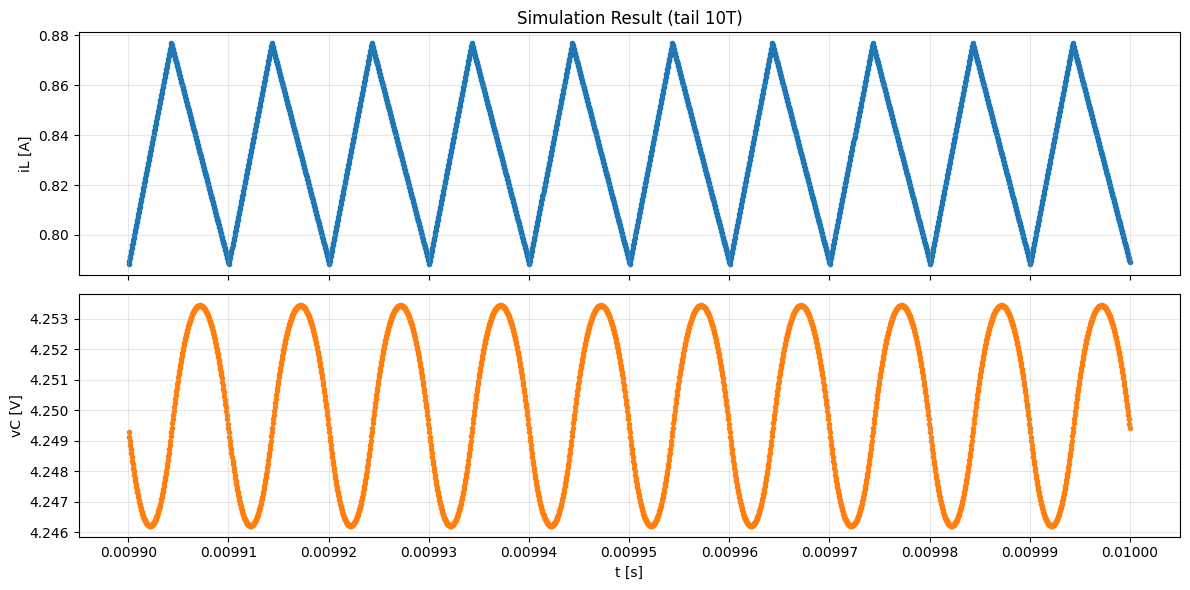

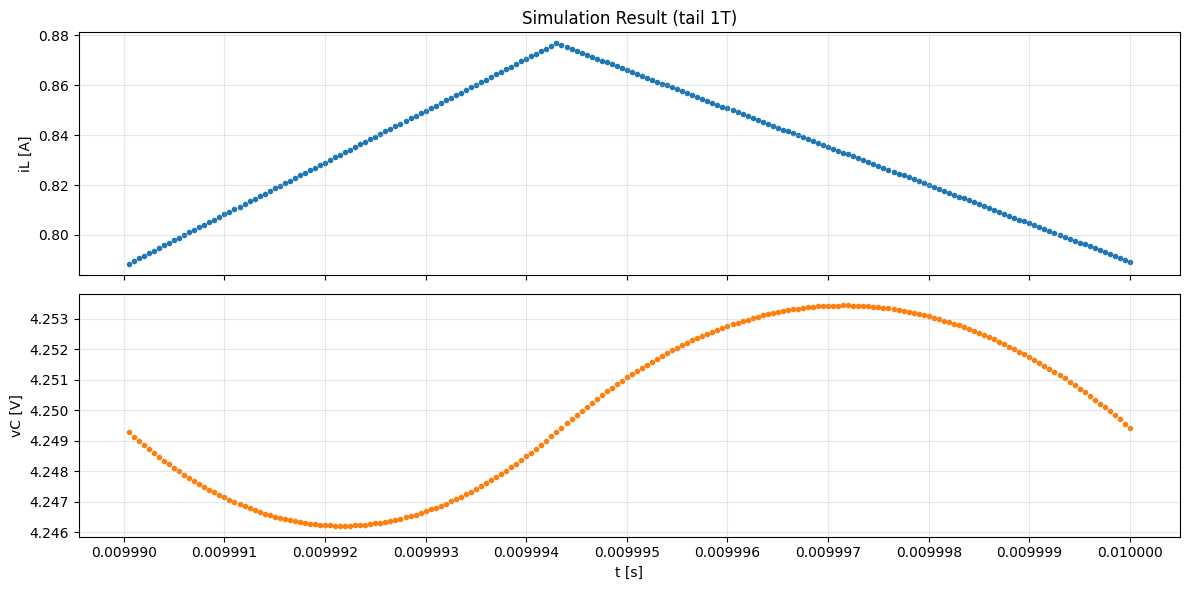

In [51]:
fig_list = plot_iLvC(
    t_sim,
    iL_sim,
    vC_sim,
    T=params.T,
    title="Simulation Result",
    plot_style="scatter",
    show_tail=(50, 10, 1),
)

if keep_log:
    for i, (fig, _) in enumerate(fig_list):
        save_figure_to_log(
            fig,
            f"シミュレーション結果_{i}",
            result_dir,
            "シミュレーション結果" if i == 0 else None,
        )


# GRU


## 前処理

1. 教師データ: (実機データのノイズクリッピング前の波形) - (学習済み BuckConverterCell のおよそ定常部分)
2. 入力データ: iL, vC, vs, u, dt
3. データシーケンスの作成
4. train, valid, test に分割


In [52]:
@dataclass(frozen=True)
class Scalers:
    """GRU入力のスケーリング設定。

    - 状態/入力は無次元化（物理基準）
    - ノイズのみ標準化（train統計）し、推論時に必ず逆変換する
    """

    # 無次元化の基準
    v_base: float  # [V]
    i_base: float  # [A]
    t_base: float  # [s]

    # ノイズ標準化（trainのみ）
    noise_mean: torch.Tensor  # (2,)
    noise_std: torch.Tensor  # (2,)

    def nondim_h(self, h: torch.Tensor) -> torch.Tensor:
        """h=[iL,vC] -> 無次元化"""
        iL = h[:, 0] / self.i_base
        vC = h[:, 1] / self.v_base
        return torch.stack([iL, vC], dim=1)

    def nondim_x(self, x: torch.Tensor) -> torch.Tensor:
        """x=[vs,u,dt] -> vs,dtを無次元化。uは0/1なのでそのまま。"""
        vs = x[:, 0] / self.v_base
        u = x[:, 1]
        dt = x[:, 2] / self.t_base
        return torch.stack([vs, u, dt], dim=1)

    def z_noise(self, noise: torch.Tensor) -> torch.Tensor:
        """noise=[iL_noise,vC_noise] -> 標準化"""
        return (noise - self.noise_mean) / self.noise_std

    def inv_z_noise(self, noise_z: torch.Tensor) -> torch.Tensor:
        """標準化ノイズ -> 元スケールへ復元"""
        return noise_z * self.noise_std + self.noise_mean


def fit_scalers_physics(
    *,
    noise_train: torch.Tensor,
    vin: float,
    r_load: float,
    t_base: float,
    eps: float = 1e-8,
) -> Scalers:
    """trainノイズから標準化統計を作り、物理基準の無次元化とセットで返す。"""
    v_base = float(vin)
    i_base = float(vin / r_load)

    noise_mean = noise_train.mean(dim=0)
    noise_std = noise_train.std(dim=0, unbiased=False).clamp_min(eps)

    return Scalers(
        v_base=v_base,
        i_base=i_base,
        t_base=float(t_base),
        noise_mean=noise_mean,
        noise_std=noise_std,
    )


def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences: list[torch.Tensor] = []
    targets: list[torch.Tensor] = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input: list[torch.Tensor] = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                # device/dtype を揃える
                noise_features = noise_data.new_zeros((2,))
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


# t_downsampled 部分を切り出す
h_sim_tensor = h_sim_tensor[-len(t_downsampled) :]
h_sim_tensor = h_sim_tensor[:-1]

iL_tensor = torch.tensor(iL_gru, dtype=torch.float32)
vC_tensor = torch.tensor(vC_gru, dtype=torch.float32)
h_meas_tensor = torch.stack([iL_tensor[:-1], vC_tensor[:-1]], dim=1)

n = min(h_meas_tensor.shape[0], h_sim_tensor.shape[0])
h_noise = h_meas_tensor[:n] - h_sim_tensor[:n]

# データセットを作成
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]
h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)

# --- スケーリング（無次元化 + ノイズ標準化） ---
noise_train_raw = h_noise[: len(h_train)]
scalers = fit_scalers_physics(
    noise_train=noise_train_raw,
    vin=float(params.Vin),
    r_load=float(params.R_true),
    t_base=float(params.T),
)

h_train_nd = scalers.nondim_h(h_train)
x_train_nd = scalers.nondim_x(x_train)
noise_train_z = scalers.z_noise(noise_train_raw)

X_train_seq, y_train_seq = create_sequences(
    h_train_nd,
    x_train_nd,
    noise_train_z,
    params.seq_length,
)

iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]
h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)

noise_valid_raw = h_noise[len(h_train) : len(h_train) + len(h_valid)]
h_valid_nd = scalers.nondim_h(h_valid)
x_valid_nd = scalers.nondim_x(x_valid)
noise_valid_z = scalers.z_noise(noise_valid_raw)

X_valid_seq, y_valid_seq = create_sequences(
    h_valid_nd,
    x_valid_nd,
    noise_valid_z,
    params.seq_length,
)


iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]
h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)

noise_test_raw = h_noise[len(h_train) + len(h_valid) :]
h_test_nd = scalers.nondim_h(h_test)
x_test_nd = scalers.nondim_x(x_test)
noise_test_z = scalers.z_noise(noise_test_raw)

X_test_seq, y_test_seq = create_sequences(
    h_test_nd,
    x_test_nd,
    noise_test_z,
    params.seq_length,
)

# 可視化/評価用のraw教師（create_sequencesの仕様より）
seq_len_int = int(params.seq_length)
y_train_seq_raw = noise_train_raw[seq_len_int:]
y_valid_seq_raw = noise_valid_raw[seq_len_int:]
y_test_seq_raw = noise_test_raw[seq_len_int:]

print(f"学習データ: {X_train_seq.shape} -> {y_train_seq.shape}")
print(f"検証データ: {X_valid_seq.shape} -> {y_valid_seq.shape}")
print(f"テストデータ: {X_test_seq.shape} -> {y_test_seq.shape}")
print(
    f"入力特徴量の次元: {X_train_seq.shape[2]} (iL, vC, vs, u, dt, iL_noise, vC_noise)"
)

学習データ: torch.Size([580, 10, 7]) -> torch.Size([580, 2])
検証データ: torch.Size([580, 10, 7]) -> torch.Size([580, 2])
テストデータ: torch.Size([778, 10, 7]) -> torch.Size([778, 2])
入力特徴量の次元: 7 (iL, vC, vs, u, dt, iL_noise, vC_noise)


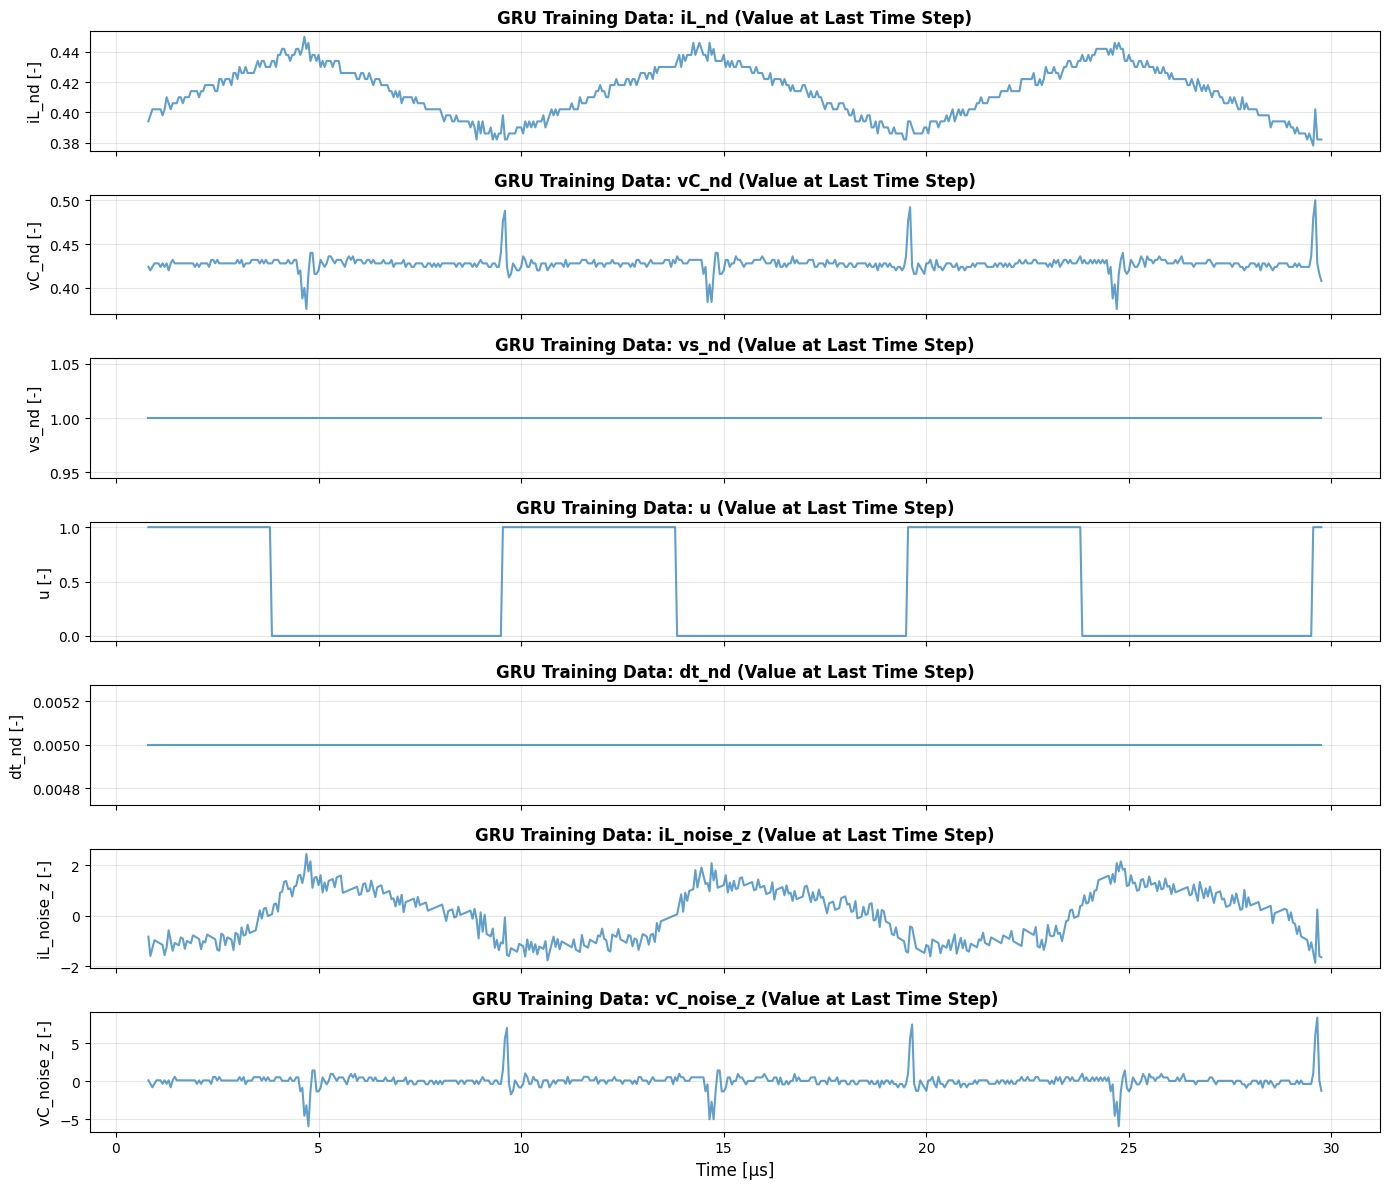

In [53]:
# 学習データ
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()
y_train_seq_np: np.ndarray = y_train_seq.detach().cpu().numpy()

# 入力特徴量名と単位（無次元化/標準化後）
feature_names: list[str] = [
    "iL_nd",
    "vC_nd",
    "vs_nd",
    "u",
    "dt_nd",
    "iL_noise_z",
    "vC_noise_z",
]
feature_units: list[str] = ["[-]", "[-]", "[-]", "[-]", "[-]", "[-]", "[-]"]


fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)

last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N, 7]

# time_axisをt_train（μs単位）に
time_axis: np.ndarray = t_train[: X_train_seq_np.shape[0]] * 1e6  # μs

for i in range(7):
    axs[i].plot(time_axis, last_timestep_features[:, i], linewidth=1.5, alpha=0.7)
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data: {feature_names[i]} (Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features",
        result_dir,
        "GRU 学習データ",
    )


## 学習


In [54]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=params.seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=params.gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(params.gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(train_loss.item())

    # 検証モード
    gru_model.eval()
    with torch.no_grad():
        noise_pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(noise_pred_valid, y_valid_seq)
        gru_loss_history["valid"].append(valid_loss.item())

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{params.gru_epochs}: "
            f"Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )

gru_model.eval()
with torch.no_grad():
    noise_pred_test = gru_model(X_test_seq)
    test_loss = gru_loss_fn(noise_pred_test, y_test_seq)
    print(f"Test Loss={test_loss.item():.6e}")


Epoch 50/200: Train Loss=5.423420e-01, Valid Loss=4.654006e-01
Epoch 100/200: Train Loss=4.971166e-01, Valid Loss=4.374670e-01
Epoch 150/200: Train Loss=4.055082e-01, Valid Loss=3.761550e-01
Epoch 200/200: Train Loss=2.031036e-01, Valid Loss=2.586682e-01
Test Loss=3.106204e-01


## 結果確認


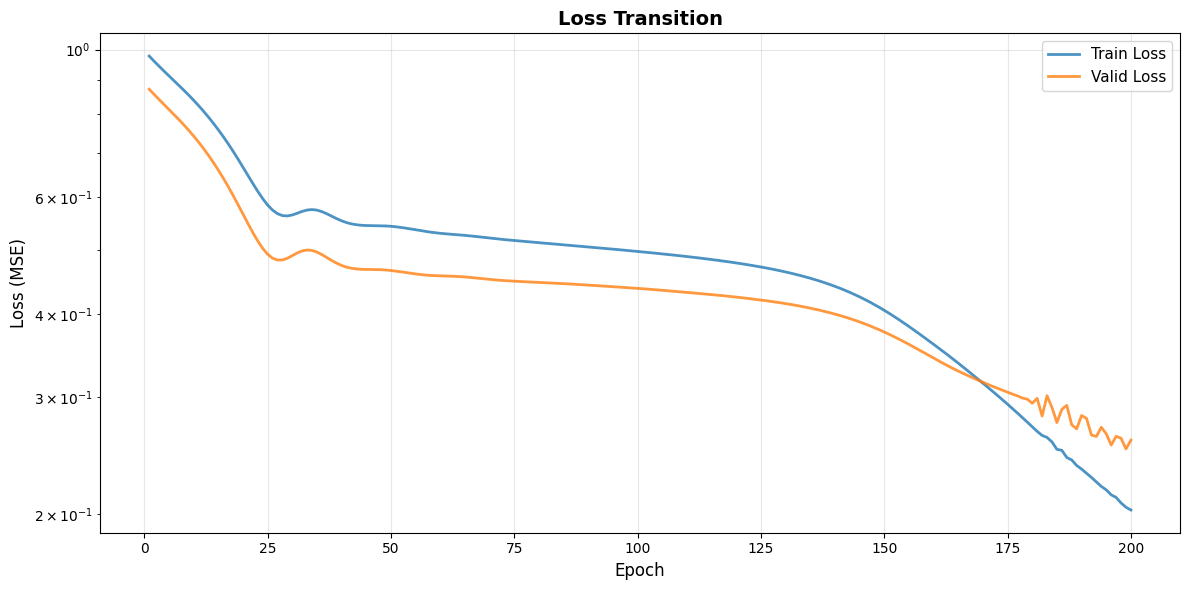

In [55]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.gru_epochs + 1)
ax.plot(
    epochs_list, gru_loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8
)
ax.plot(
    epochs_list, gru_loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8
)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "gru_loss_transition", result_dir, "GRU Lossの遷移")


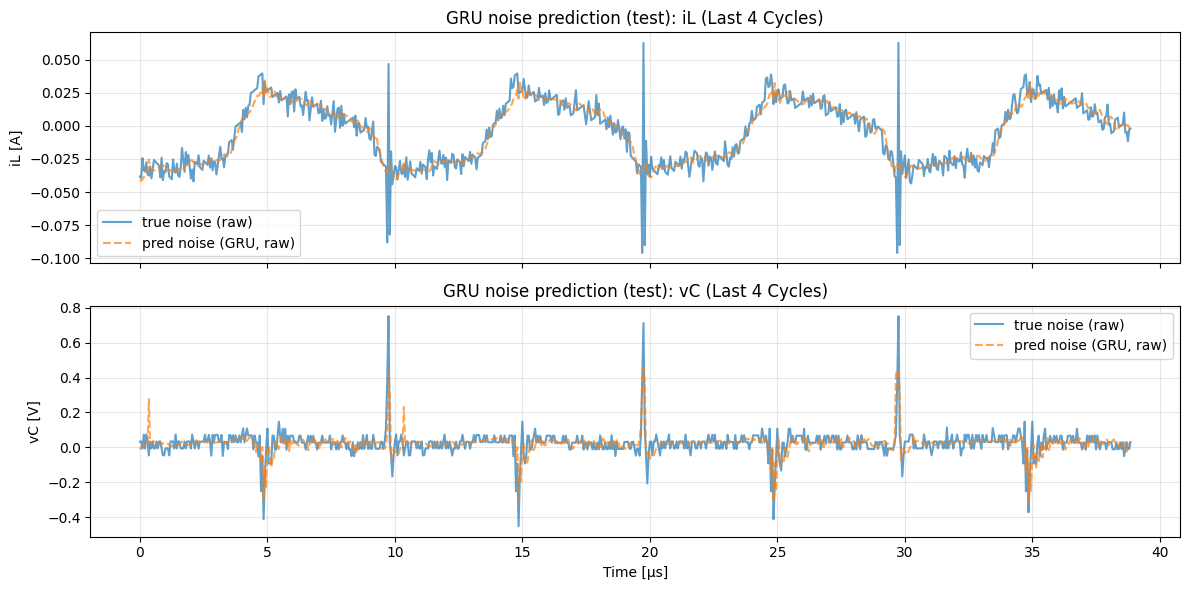

In [56]:
# GRUでノイズを予測（テスト）
gru_model.eval()
with torch.no_grad():
    noise_pred_test = gru_model(X_test_seq)


noise_pred_test_cpu = noise_pred_test.detach().cpu()
noise_true_test_cpu = y_test_seq.detach().cpu()

# plot_compare_tail を使って比較（末尾N周期）
seq_len = int(params.seq_length)

t_noise = np.asarray(t_test[:-1])[seq_len:]
min_len = min(
    t_noise.shape[0],
    int(noise_true_test_cpu.shape[0]),
    int(noise_pred_test_cpu.shape[0]),
)

t_noise = t_noise[:min_len]
true_noise_z = noise_true_test_cpu[:min_len].numpy()
pred_noise_z = noise_pred_test_cpu[:min_len].numpy()

# 標準化ノイズ -> rawノイズへ復元（推論時に必ず戻す）
true_noise_raw = y_test_seq_raw[:min_len].detach().cpu().numpy()
pred_noise_raw = scalers.inv_z_noise(noise_pred_test_cpu[:min_len]).numpy()

fig1, _ = plot_compare_tail(
    t1=t_noise,
    iL1=true_noise_raw[:, 0],
    vC1=true_noise_raw[:, 1],
    label1="true noise (raw)",
    t2=t_noise,
    iL2=pred_noise_raw[:, 0],
    vC2=pred_noise_raw[:, 1],
    label2="pred noise (GRU, raw)",
    T=float(params.T),
    N_cycles=4,
    title="GRU noise prediction (test)",
)


if keep_log:
    save_figure_to_log(
        fig1,
        "gru_noise_pred_test",
        result_dir,
        "GRU noise予測(テスト)",
    )


# BuckConverterCell + GRU の結果


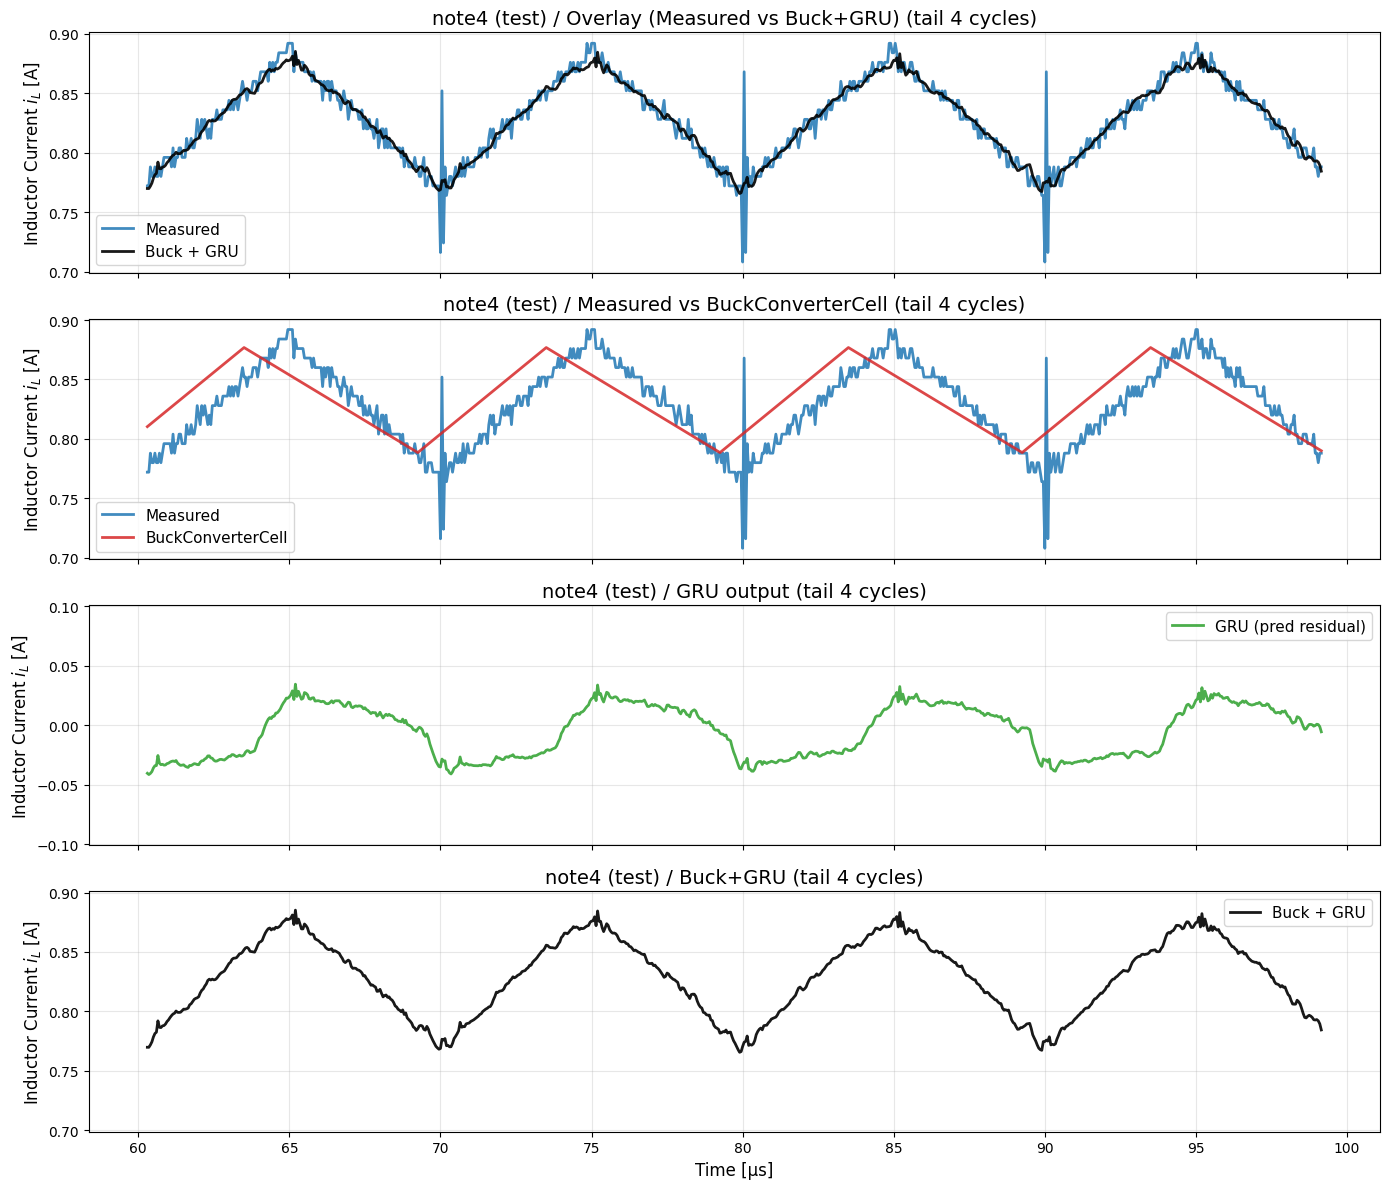

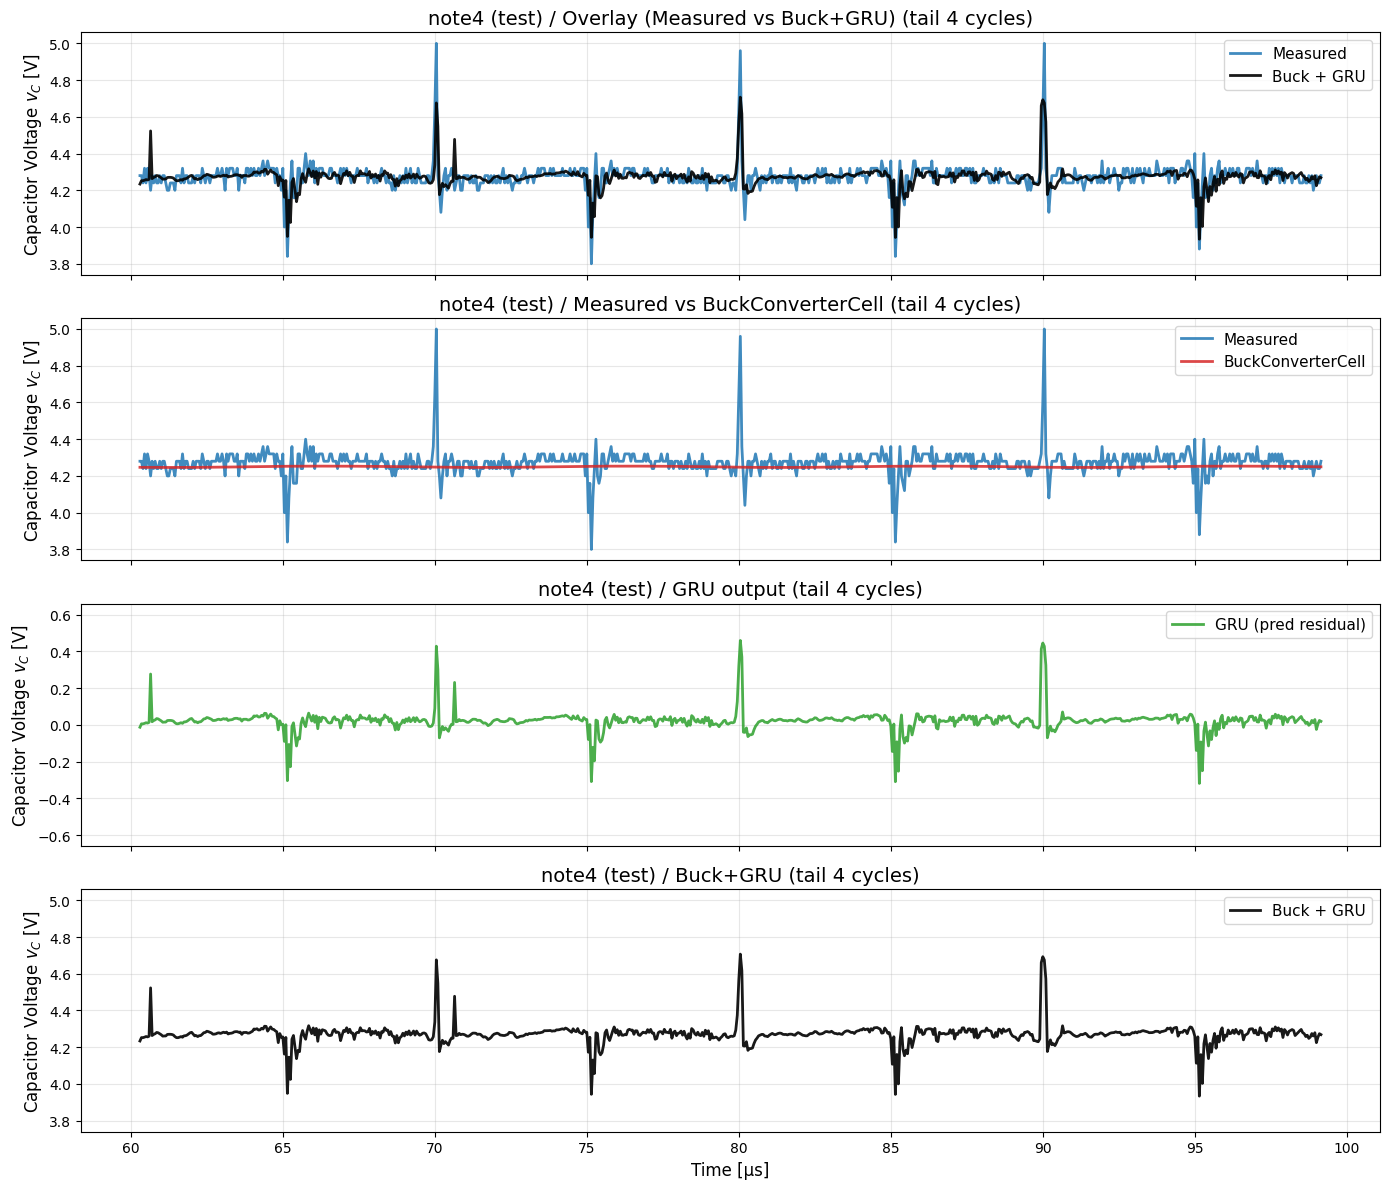

In [57]:
# プロット
N_cycles: int = 4
T: float = float(params.T)
seq_len: int = int(params.seq_length)

# --- BuckConverterCell: 実機時間(t_downsampled)に対応する末尾部分を抽出 ---
n_meas: int = int(len(t_downsampled))
t_sim_meas_raw: np.ndarray = np.asarray(t_sim[-n_meas:], dtype=float)

iL_sim_meas: np.ndarray = np.asarray(
    iL_sim[-n_meas:].detach().cpu().numpy(), dtype=float
)
vC_sim_meas: np.ndarray = np.asarray(
    vC_sim[-n_meas:].detach().cpu().numpy(), dtype=float
)

# t_sim末尾は (t_downsampled + offset) なので、offset を引いて合わせる
offset: float = float(t_sim_meas_raw[0] - float(t_downsampled[0]))
t_sim_meas: np.ndarray = t_sim_meas_raw - offset  # ≒ t_downsampled

# --- test区間をBuck側の時間で切り出す ---
t_test_np: np.ndarray = np.asarray(t_test, dtype=float)
start_idx: int = int(np.argmin(np.abs(t_sim_meas - float(t_test_np[0]))))
end_idx: int = min(start_idx + int(t_test_np.shape[0]), int(t_sim_meas.shape[0]))

t_test_used: np.ndarray = t_sim_meas[start_idx:end_idx]
iL_sim_test: np.ndarray = iL_sim_meas[start_idx:end_idx]
vC_sim_test: np.ndarray = vC_sim_meas[start_idx:end_idx]

# --- Measured(test) を同じ長さだけ取り出す ---
start_test_idx: int = int(train_len + valid_len)  # t_testと同じ開始位置

iL_meas_test: np.ndarray = np.asarray(
    iL_gru[start_test_idx : start_test_idx + int(t_test_used.shape[0])], dtype=float
)
vC_meas_test: np.ndarray = np.asarray(
    vC_gru[start_test_idx : start_test_idx + int(t_test_used.shape[0])], dtype=float
)

# --- GRU出力(pred_noise)は t_test[:-1][seq_len:] に対応 ---
t_noise_local: np.ndarray = np.asarray(t_test_used[:-1], dtype=float)[seq_len:]
# pred_noise_raw はセル24で「標準化->raw復元」済み
pred_noise_np: np.ndarray = np.asarray(pred_noise_raw, dtype=float)

min_len2: int = int(
    min(
        t_noise_local.shape[0],
        pred_noise_np.shape[0],
        iL_sim_test.shape[0] - 1 - seq_len,
        vC_sim_test.shape[0] - 1 - seq_len,
        iL_meas_test.shape[0] - 1 - seq_len,
        vC_meas_test.shape[0] - 1 - seq_len,
    )
)

if min_len2 <= 0:
    raise ValueError(
        "長さが合わず、描画できません。"
        " t_test/t_sim/pred_noise/seq_length の整合を確認してください。"
    )

# すべて同じ長さに揃える
# t は [s]
t_view: np.ndarray = t_noise_local[:min_len2]

iL_meas: np.ndarray = np.asarray(iL_meas_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]
vC_meas: np.ndarray = np.asarray(vC_meas_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]

iL_buck: np.ndarray = np.asarray(iL_sim_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]
vC_buck: np.ndarray = np.asarray(vC_sim_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]

iL_gru: np.ndarray = pred_noise_np[:min_len2, 0]
vC_gru: np.ndarray = pred_noise_np[:min_len2, 1]

fig_iL, _, fig_vC, _ = plot_buck_gru_components_tail(
    t=t_view,
    iL_meas=iL_meas,
    vC_meas=vC_meas,
    iL_buck=iL_buck,
    vC_buck=vC_buck,
    iL_gru=iL_gru,
    vC_gru=vC_gru,
    T=T,
    N_cycles=float(N_cycles),
    title="note4 (test)",
    include_overlay=True,
)
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "tail4T_iL_meas_buck_gru_sum",
        result_dir,
        "iL: Measured / Buck / GRU / Buck+GRU（末尾4周期）",
    )
    save_figure_to_log(
        fig_vC,
        "tail4T_vC_meas_buck_gru_sum",
        result_dir,
        "vC: Measured / Buck / GRU / Buck+GRU（末尾4周期）",
    )
